<a href="https://colab.research.google.com/github/hargurjeet/LJMU_Thesis/blob/main/ExperimentThresholdAdjustments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hargurjeet/LJMU_Thesis.git

Cloning into 'LJMU_Thesis'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 126 (delta 69), reused 9 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (126/126), 552.27 KiB | 5.36 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [5]:
!pip install pandas openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb

In [8]:
df_open_ai = pd.read_csv("/content/LJMU_Thesis/Processed_output/openai_generated_output.csv")
df_open_ai.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target,TextualData
0,34,No,Middle Income,6,No,Yes,0,The customer is 34 years old and has indicated...
1,34,Yes,Low Income,5,Yes,No,1,The customer is aged 34 and is a frequent flye...
2,37,No,Middle Income,3,Yes,No,0,The customer is 37 years old and is not a freq...
3,30,No,Middle Income,2,No,No,0,The customer is aged 30 and is not a frequent ...
4,30,No,Low Income,1,No,No,0,"The customer is 30 years old, does not frequen..."


## Generating embeddings for OpenAI model

In [6]:
import openai

openai.api_key = ''

In [12]:
def get_embedding(text):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=text
    )
    return response['data'][0]['embedding']

df_open_ai['Embedding'] = df_open_ai['TextualData'].apply(get_embedding)

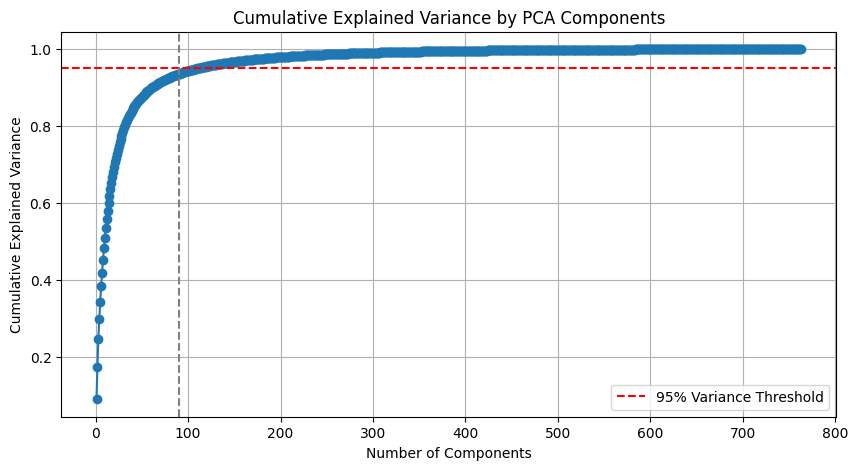

In [13]:
import matplotlib.pyplot as plt
# Prepare data
X = df_open_ai['Embedding'].tolist()
y = df_open_ai['Target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA and determine the explained variance
pca = PCA()
pca.fit(X_train)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=90, color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.show()

## Training models

In [14]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_open_ai['Embedding'].tolist(),
    df_open_ai['Target'],
    test_size=0.2,
    random_state=42
)

# Standardize the embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
# pca = PCA(n_components=min(len(X_train), X_train.shape[1]))
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_pca)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       153
           1       0.78      0.18      0.30        38

    accuracy                           0.83       191
   macro avg       0.80      0.59      0.60       191
weighted avg       0.82      0.83      0.78       191



In [15]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
xgb_model.fit(X_train_pca, y_train)
y_pred = xgb_model.predict(X_test_pca)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       153
           1       0.64      0.42      0.51        38

    accuracy                           0.84       191
   macro avg       0.75      0.68      0.71       191
weighted avg       0.82      0.84      0.82       191



## Threshold experiment with XGB classifier

In [17]:
y_pred_proba = xgb_model.predict_proba(X_test_pca)[:, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report with Threshold {threshold}:")
    print(report)
    print()

Classification Report with Threshold 0.1:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       153
           1       0.60      0.84      0.70        38

    accuracy                           0.86       191
   macro avg       0.78      0.85      0.81       191
weighted avg       0.89      0.86      0.87       191


Classification Report with Threshold 0.2:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       153
           1       0.62      0.74      0.67        38

    accuracy                           0.86       191
   macro avg       0.78      0.81      0.79       191
weighted avg       0.87      0.86      0.86       191


Classification Report with Threshold 0.3:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       153
           1       0.58      0.55      0.57        38

    accuracy                           0.83       191
